# Money Ball 1 - Which teams will make the 2023 World Series?

* Marcos Fassio Bazzi - marcosfassiob18
* Peter Do - kyungwan
* Grant Collier - gcollier24
* Ajay Kanjoor - ajkanjoor03

Our goal for this project is to try to predict the 2023 MLB season and predict who will make the World Series based off of the data we can find on [Baseball Reference](https://www.baseball-reference.com/) and [Spotrac](https://www.spotrac.com/mlb/payroll/2022/), two websites dedicated to baseball statistics and payroll data, respectively.

## How does the MLB Regular Season work and how do teams make the World Series?

Major League Baseball is split up into two leagues: National League and American League. For each league, there are three conferences (East, Central and West) and each conference has five teams, making a total of 30 teams in MLB. Each team plays the four other teams in their division 19 times and the 10 other teams in their conference between six and seven times. This totals to 162 games for every team in the regular season. 

This year, 12 teams (six from each conference) make playoffs. The playoffs are stuctured as a six-team seeded single-elimination bracket, where one side represents the Atlantic League and the other representing the National League. In each conference, the #1 and #2 seed automatically advance to the semifinals while the #3 to #6 seends play in the quarterfinals. The winners of each conference make it to the World Series.

Below is a visualization of the MLB Playoffs format: 

![assets/playoffs_format.jpeg](assets/playoffs_format.jpeg)

For more information on the playoffs format, click [here](https://www.mlb.com/news/mlb-playoff-format-faq)

# Scraping, cleaning, grouping and visualizing the data

Exporting the data from Baseball Reference is easy enough - the site has an option that allows us to share and export as a `.csv` file. However, the same cannot be said for Spotrac. In this case, we used Python libraries `requests` and `BeautifulSoup4` to fetch and scrape the payroll data from Spotrac.

## Importing necessary libraries

In [26]:
import requests
import bs4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

In [27]:
plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline

## Scraping and cleaning the 2022 payroll data

In [28]:
# fetch link and get page
url = "https://www.spotrac.com/mlb/payroll/2022/"
header = { "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36" }
link = requests.get(url, headers=header)
soup = bs4.BeautifulSoup(link.content, "html5lib")

## get table and parse headers
table_data = soup.find('table', { "class": "datatable" })
headers = [i.text.strip() for i in table_data.find_all("th")]

## parse table body
table_body = soup.find("tbody")
team_data = []
for row_data in table_body.find_all("tr"):
    team_data += [[entry.text.strip().replace("\n", "").replace("\t", "") for entry in row_data.find_all("td")]]

# clean team names
for i in range(len(team_data)):
    team_data[i][1] = team_data[i][1][:-3] # last three characters are the team's abbreviation - we don't want this
team_data[4][1] = "San Diego Padres" # for whatever reason this entry's abbreviation was two characters instead of three
team_data.pop(14)
team_data.pop(14) # get rid of league averages in table

# turn data into dataframe
dirty_payroll_data_2022 = pd.DataFrame(team_data, columns=headers)

# cleaning 2022 payroll data
payroll_data_2022 = dirty_payroll_data_2022.copy()
payroll_data_2022 = dirty_payroll_data_2022.replace('0-','0').replace('\$','',regex=True).replace(',','', regex=True)
payroll_data_2022 = payroll_data_2022.loc[:, ['Team', '2022 Total Payroll']]
payroll_data_2022 = payroll_data_2022.astype({ '2022 Total Payroll':'int' })

payroll_data_2022.head()

,Team,2022 Total Payroll
0,Los Angeles Dodgers,270381426
1,New York Mets,268292506
2,New York Yankees,252957200
3,Philadelphia Phillies,244484097
4,San Diego Padres,224511694


## Scraping and cleaning the 2023 payroll data

The process is identical.

In [29]:
# fetch link and get page
url = "https://www.spotrac.com/mlb/payroll/2023/"
header = { "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36" }
link = requests.get(url, headers=header)
soup = bs4.BeautifulSoup(link.content, "html5lib")

## get table and parse headers
table_data = soup.find('table', { "class": "datatable" })
headers = [i.text.strip() for i in table_data.find_all("th")]

## parse table body
table_body = soup.find("tbody")
team_data = []
for row_data in table_body.find_all("tr"):
    team_data += [[entry.text.strip().replace("\n", "").replace("\t", "") for entry in row_data.find_all("td")]]

# clean team names
for i in range(len(team_data)):
    team_data[i][1] = team_data[i][1][:-3] # last three characters are the team's abbreviation - we don't want this
team_data[4][1] = "San Diego Padres" # for whatever reason this entry's abbreviation was two characters instead of three
team_data.pop(14) # get rid of league averages in table
team_data.pop(14)
team_data.pop(14)
team_data.pop(14)

# turn data into dataframe
dirty_payroll_data_2023 = pd.DataFrame(team_data, columns=headers)

# cleaning 2023 payroll data
payroll_data_2023 = dirty_payroll_data_2023.copy()
payroll_data_2023 = dirty_payroll_data_2023.replace('0-','0').replace('\$','',regex=True).replace(',','', regex=True)
payroll_data_2023 = payroll_data_2023.loc[:, ['Team', '2023 Total Payroll']]
payroll_data_2023 = payroll_data_2023.astype({ '2023 Total Payroll':'int' })

payroll_data_2023.head()

,Team,2023 Total Payroll
0,New York Mets,345847094
1,New York Yankees,279047468
2,San Diego Padre,245847510
3,Philadelphia Phillies,243446676
4,San Diego Padres,227497450


## Fetching the necessary data from 2022 MLB team data from Baseball Reference

One problem we noticed while exporting the data from Baseball Reference is that a lot of the columns in these tables are unecessary and don't provide much insight, such as the number of games played. While revising this project for Part 3, we picked out the more significant columns, such as a team's runs batted in or slugs.

Another shortcoming we had to deal with is renaming some columns that overlapped on the batting and pitching data. We solved this by subscripting said columns with `x` for the batting data and `y` for the pitching data.

We copied both the batting and pitching data per team as a `.csv` file and exported it, and then renamed the `Tm` column to `Team` to group our data more easily.

In [30]:
batting_data_2022_raw = pd.read_csv("data/batting_data_2022.csv")
batting_data_2022 = batting_data_2022_raw.rename(columns={ "Tm": "Team" })

batting_data_2022.head()

,Team,R,H,HR,RBI,SO,BA,OBP,SLG,OPS,OPS+,TB
0,Arizona Diamondbacks,702,1232,173,658,1341,0.230,0.304,0.385,0.689,95,2061
1,Atlanta Braves,789,1394,243,753,1498,0.253,0.317,0.443,0.761,111,2443
2,Baltimore Orioles,674,1281,171,639,1390,0.236,0.305,0.390,0.695,97,2119
3,Boston Red Sox,735,1427,155,704,1373,0.258,0.321,0.409,0.731,102,2268
4,Chicago Cubs,657,1293,159,620,1448,0.238,0.311,0.387,0.698,96,2097


In [31]:
pitching_data_2022_raw = pd.read_csv("data/pitching_data_2022.csv")
pitching_data_2022 = pitching_data_2022_raw.rename(columns={ "Tm": "Team" })

pitching_data_2022.head()

,Team,W-L%,ERA,tSho,H,R,HR,BB,SO,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,Arizona Diamondbacks,0.457,4.25,10,1345,740,191,504,1216,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41
1,Atlanta Braves,0.623,3.46,9,1224,609,148,500,1554,118,3.46,1.191,7.6,0.9,3.1,9.7,3.11
2,Baltimore Orioles,0.512,3.97,15,1406,688,171,443,1214,102,4.03,1.290,8.8,1.1,2.8,7.6,2.74
3,Boston Red Sox,0.481,4.53,10,1411,787,185,526,1346,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56
4,Chicago Cubs,0.457,4.00,11,1342,731,207,540,1383,103,4.33,1.304,8.4,1.3,3.4,8.6,2.56


## Grouping the 2022 payroll and baseball data

After cleaning the data above, we grouped the data together using two many-to-one joins based on the team name.

In [32]:
baseball_data_2022 = pd.merge(batting_data_2022, pitching_data_2022, on=["Team"]) # merge baseball reference stats
baseball_data_2022 = pd.merge(baseball_data_2022, payroll_data_2022, on=["Team"]) # merge payroll stats

baseball_data_2022.head()

,Team,R_x,H_x,HR_x,RBI,SO_x,BA,OBP,SLG,OPS,...,SO_y,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,2022 Total Payroll
0,Arizona Diamondbacks,702,1232,173,658,1341,0.230,0.304,0.385,0.689,...,1216,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41,85964090
1,Atlanta Braves,789,1394,243,753,1498,0.253,0.317,0.443,0.761,...,1554,118,3.46,1.191,7.6,0.9,3.1,9.7,3.11,183438888
2,Baltimore Orioles,674,1281,171,639,1390,0.236,0.305,0.390,0.695,...,1214,102,4.03,1.290,8.8,1.1,2.8,7.6,2.74,44888388
3,Boston Red Sox,735,1427,155,704,1373,0.258,0.321,0.409,0.731,...,1346,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56,211812131
4,Chicago Cubs,657,1293,159,620,1448,0.238,0.311,0.387,0.698,...,1383,103,4.33,1.304,8.4,1.3,3.4,8.6,2.56,151054737


### What does each statistic mean?

|Batting Data|Pitching Data|
|--|--|
|<table><thead><tr><th>Statistic</th><th>Description</th></tr></thead><tbody><tr><td>R_x</td><td>Runs</td></tr><tr><td>H_x</td><td>Hits</td></tr><tr><td>HR_x</td><td>Home runs</td></tr><tr><td>RBI</td><td>Runs batted in</td></tr><tr><td>SO_x</td><td>Strikeouts</td></tr><tr><td>BA</td><td>Batting average</td></tr><tr><td>OBP</td><td>On-base percentage</td></tr><tr><td>SLG</td><td>Slugs</td></tr><tr><td>OPS</td><td>OBP + slugs</td></tr><tr><td>OPS+</td><td>OPS normalized across league</td></tr><tr><td>TB</td><td>Total bases gained</td></tr></tbody></table>| <table><thead><tr><th>Statistic</th><th>Description</th></tr></thead><tbody><tr><td>W-L%</td><td>Win-loss percentage</td></tr><tr><td>ERA</td><td>Earned run average</td></tr><tr><td>tSho</td><td>Team shutouts</td></tr><tr><td>H_y</td><td>Hits allowed</td></tr><tr><td>R_y</td><td>Runs allowed</td></tr><tr><td>HR</td><td>Home runs allowed</td></tr><tr><td>BB</td><td>Base on balls (walks)</td></tr><tr><td>SO_y</td><td>Shutouts</td></tr><tr><td>ERA+</td><td>Earned run average (normalized)</td></tr><tr><td>FIP</td><td>Fielding independent pitching</td></tr><tr><td>WHIP</td><td>Walks and hits per inning pitched</td></tr><tr><td>HR9</td><td>Home runs per nine innings</td></tr><tr><td>BB9</td><td>Walks per nine innings</td></tr><tr><td>SO9</td><td>Shutouts per nine innings</td></tr><tr><td>SO/W</td><td>Shutouts per walk</td></tr></tbody></table>|

More on what each statistic means [here](https://www.baseball-reference.com/bullpen/Baseball_statistics#:~:text=Batting%20average%2C%20RBIs%2C%20and%20home,most%20often%20cited%20traditional%20statistics.)

# Proceesing our 2022 baseball data

Now that we scraped, cleaned and grouped the data we needed, our next step is to correlate what data leads to the highest win ratio. We all agreed on using the win-loss ratio as our benchmark because the team with the highest win ratio makes it to the highest seed in playoffs, thus making said team's chances to make the World Series a lot higher.

Our plan is to normalize our data, create a correlation matrix with the `W-L%` statistic, find the team that fits this matrix best and report our findings. ***WE NEED TO WORK ON THIS PART***

***I ALSO THINK WE DITCH THE SCATTERPLOT MATRIX AND REPORT IT AS A NULL FINDING BECAUSE AT THIS POINT IT'S REDUNDANT***

## Normalizing our 2022 baseball data

A lot of the statistics and numerics in our data vary very largely between columns, so we z-scored our data to standardize our statistics and make our calculations more accurate and precise.

In [33]:
norm = (baseball_data_2022 - baseball_data_2022.mean())/baseball_data_2022.std()
norm = norm.drop('Team', axis=1)
norm.head()

C:\Users\marco\AppData\Local\Temp/ipykernel_12604/3229188547.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z = (baseball_data_2022 - baseball_data_2022.mean())/baseball_data_2022.std()


,2022 Total Payroll,BA,BB,BB9,ERA,ERA+,FIP,H9,HR9,HR_x,...,R_y,SLG,SO/W,SO9,SO_x,SO_y,TB,W-L%,WHIP,tSho
0,-1.031087,-1.045480,0.116346,0.220102,0.511520,-0.550141,0.896170,0.373667,0.573168,-0.087932,...,0.519080,-0.421867,-0.829994,-1.201344,-0.163264,-1.235463,-0.617376,-0.487061,0.301386,-0.380747
1,0.447377,0.798960,0.041995,-0.062886,-0.894501,1.031515,-1.352872,-1.002106,-1.283897,1.890547,...,-0.910815,1.787643,0.729339,1.606993,1.337983,1.558796,1.747129,1.290632,-0.719544,-0.614388
2,-1.654110,-0.564322,-1.017515,-0.911850,0.013184,-0.068768,0.120638,0.832257,-0.045853,-0.144460,...,-0.048512,-0.231392,-0.094880,-1.341761,0.305278,-1.251997,-0.258367,0.101934,0.271358,0.787455
3,0.877733,1.199926,0.525280,0.503090,1.009857,-0.687677,0.482553,0.985121,0.573168,-0.596684,...,1.032095,0.492413,-0.495852,-0.078009,0.142723,-0.160748,0.663914,-0.230045,0.911942,-0.380747
4,-0.043815,-0.403935,0.785510,0.786077,0.066577,0.000000,0.896170,0.220803,1.192190,-0.483628,...,0.420843,-0.345677,-0.495852,0.062407,0.859879,0.145132,-0.394543,-0.487061,0.411486,-0.147107


## Creating a scatterplot matrix with the 2022 baseball data

Using this scatterplot matrix we will be able to see how correlated different statistics are to each other. We are interested in seeing which statistics are most correlated to win percentage.

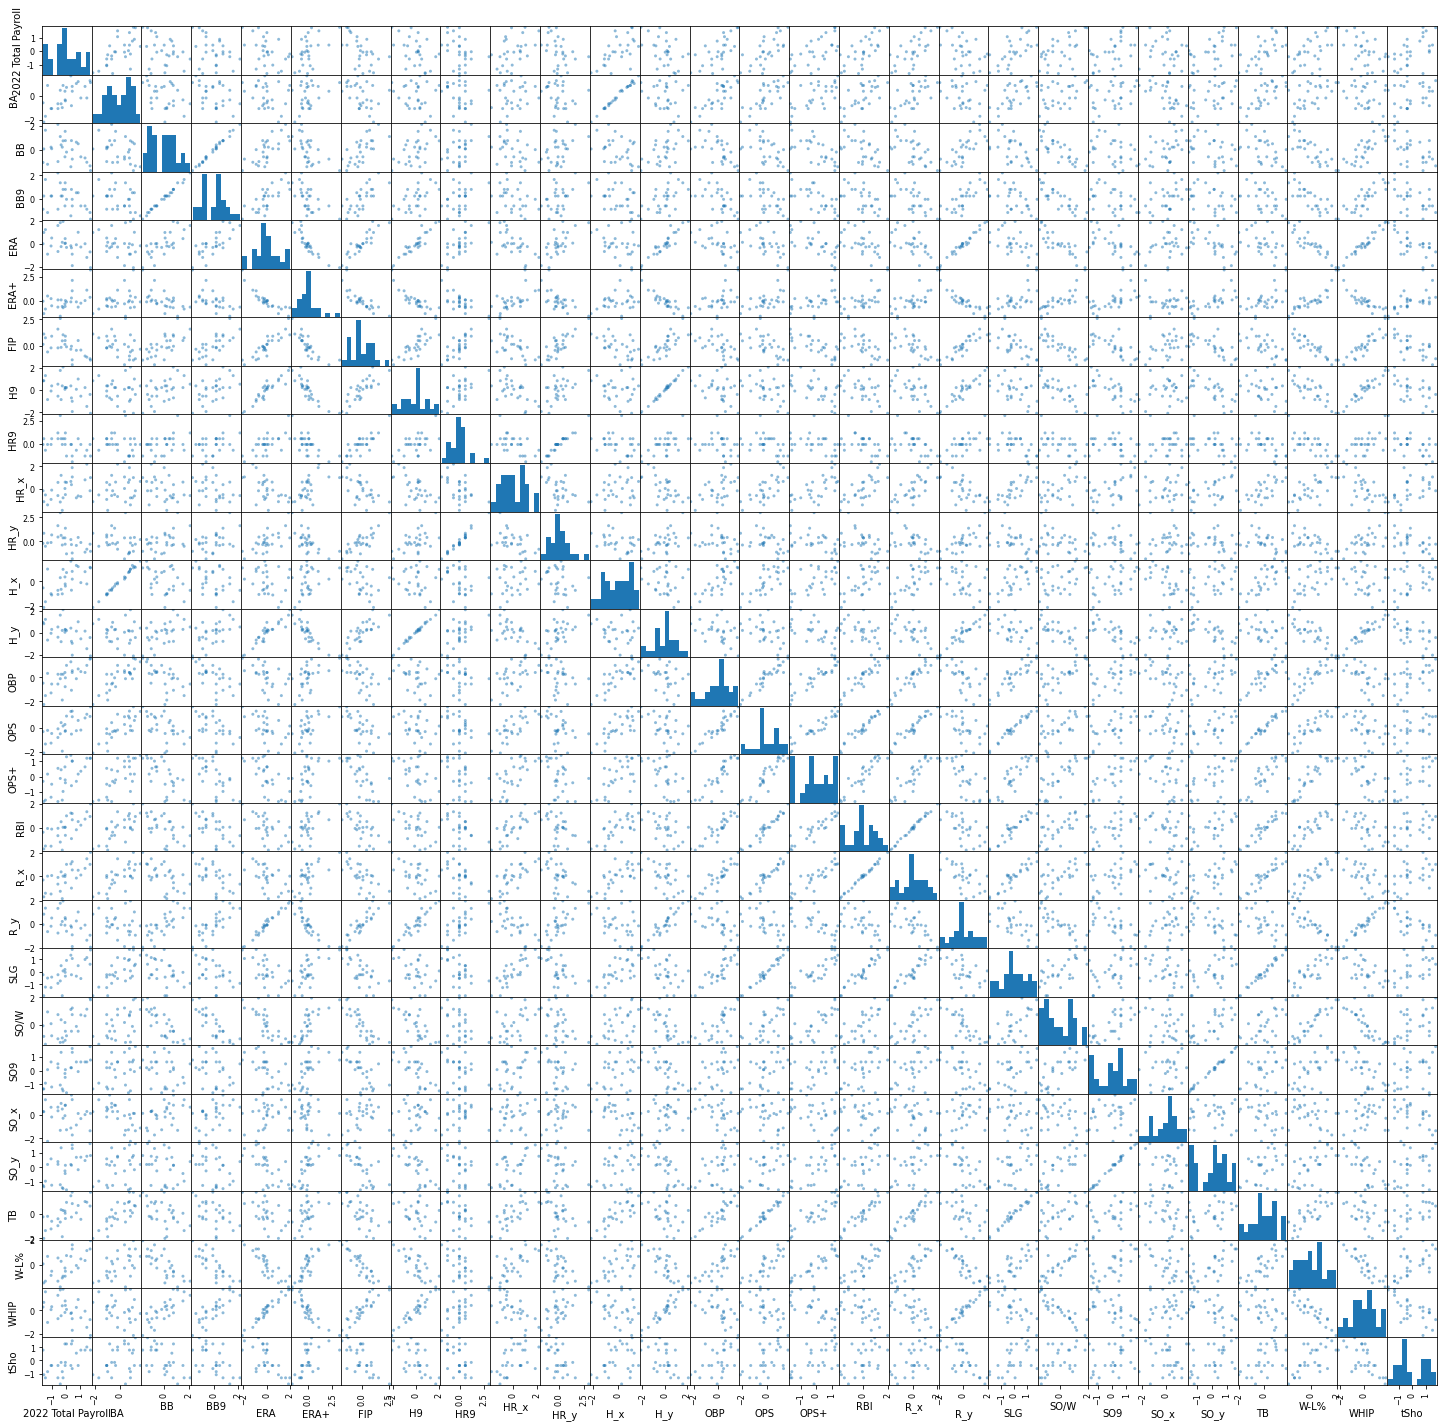

In [52]:
scatter_matrix = pd.plotting.scatter_matrix(norm, figsize=(25,25))

scatter_matrix; # semicolon suppresses text output

## Creating the win-loss correlation table 

We find the win-loss correlation table by using the `corr()` function to create a correlation matrix. Then, we create another table sorting it by `W-L%`. A correlation of $\pm 0.7$ is considered highly correlated.

In [35]:
cmatrix = norm.corr()

win_loss_table = cmatrix[['W-L%']].sort_values(by='W-L%', ascending=True)
win_loss_table.head()

,2022 Total Payroll,BA,BB,BB9,ERA,ERA+,FIP,H9,HR9,HR_x,...,R_y,SLG,SO/W,SO9,SO_x,SO_y,TB,W-L%,WHIP,tSho
2022 Total Payroll,1.000000,0.637478,-0.350505,-0.370242,-0.455472,0.507257,-0.565826,-0.465851,-0.372716,0.471815,...,-0.474915,0.672894,0.574605,0.582771,-0.131207,0.577595,0.690944,0.602026,-0.489102,0.586184
BA,0.637478,1.000000,-0.398095,-0.415663,-0.260873,0.343183,-0.399971,-0.148308,-0.223527,0.221243,...,-0.257563,0.712971,0.472140,0.338439,-0.580214,0.337358,0.796426,0.552680,-0.272161,0.303652
BB,-0.350505,-0.398095,1.000000,0.994482,0.730746,-0.590402,0.699564,0.545976,0.421095,-0.329046,...,0.760241,-0.498737,-0.839875,-0.288823,0.458433,-0.311127,-0.491803,-0.788150,0.787208,-0.557992
BB9,-0.370242,-0.415663,0.994482,1.000000,0.753243,-0.608512,0.731554,0.573453,0.448420,-0.349364,...,0.773090,-0.519718,-0.856737,-0.326041,0.425829,-0.350801,-0.518313,-0.805288,0.806016,-0.561433
ERA,-0.455472,-0.260873,0.730746,0.753243,1.000000,-0.888746,0.894091,0.933815,0.675219,-0.563279,...,0.986215,-0.562080,-0.835168,-0.599870,0.173276,-0.631152,-0.531333,-0.877022,0.970702,-0.680103


## Win percentage correlation bar graph

The table above doesn't do a good job at showing what statistics win-loss ratio is best correlated to. This bar graph, however, does.

<AxesSubplot:>

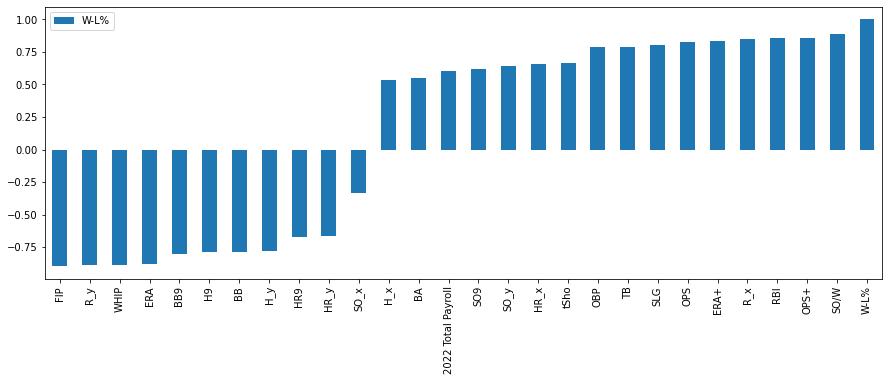

In [37]:
win_loss_table.plot.bar(figsize=(15, 5)); # semicolon suppresses text output

## Using MDS dimension reduction to determine which baseball statistics are most similar to each other

In [38]:
Distancetable = norm.transpose()
Distancetable

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2022 Total Payroll,-1.031087,0.447377,-1.654110,0.877733,-0.043815,0.747188,-0.583592,-1.326654,-0.211304,-0.267798,...,1.501807,-1.600181,1.373290,-1.482781,1.070356,-0.577956,0.037690,-0.059245,0.350801,-0.411558
BA,-1.045480,0.798960,-0.564322,1.199926,-0.403935,1.039540,-0.644515,0.879154,0.879154,-0.965287,...,-0.163356,-2.168183,0.798960,-1.687024,-0.163356,-1.045480,0.718767,-0.323742,1.681084,0.478188
BB,0.116346,0.041995,-1.017515,0.525280,0.785510,0.655395,2.123838,-1.166218,0.766922,0.246462,...,-0.998927,0.097759,-0.645757,1.640553,-0.552818,-0.943163,-0.162472,1.547614,-1.370684,1.120092
BB9,0.220102,-0.062886,-0.911850,0.503090,0.786077,0.503090,2.201017,-1.194838,0.786077,0.220102,...,-0.911850,0.220102,-0.628862,1.635041,-0.628862,-0.911850,-0.062886,1.352053,-1.477826,1.352053
ERA,0.511520,-0.894501,0.013184,1.009857,0.066577,-0.075805,1.597182,-0.894501,1.953137,0.137768,...,-1.179265,0.992059,0.013184,1.241228,-0.271580,-0.663131,-0.307176,0.458127,-0.164794,1.846351
ERA+,-0.550141,1.031515,-0.068768,-0.687677,0.000000,-0.137535,-0.687677,0.481374,-0.756444,-0.618909,...,1.100283,-1.375353,0.000000,-0.893980,-0.275071,0.068768,-0.137535,-0.618909,-0.137535,-1.650424
FIP,0.896170,-1.352872,0.120638,0.482553,0.896170,-0.448085,1.568298,-0.603191,1.025425,0.456702,...,-1.094362,1.102979,-0.990957,0.741064,-0.422234,-0.215426,-0.112021,0.482553,-0.344681,2.576489
H9,0.373667,-1.002106,0.832257,0.985121,0.220803,0.067939,0.526530,-0.849242,2.055166,0.373667,...,-1.460697,0.832257,0.220803,1.290848,-0.543515,-0.543515,0.220803,0.220803,0.373667,1.749439
HR9,0.573168,-1.283897,-0.045853,0.573168,1.192190,-0.664875,1.192190,-0.045853,0.573168,-0.045853,...,-0.664875,0.573168,-1.283897,-0.664875,-0.045853,0.573168,-1.283897,-0.045853,-0.045853,3.049255
HR_x,-0.087932,1.890547,-0.144460,-0.596684,-0.483628,-0.766268,-0.568420,-1.388076,-0.766268,-1.868564,...,2.201450,-1.105436,0.816515,-0.511892,-0.653212,0.590403,0.590403,0.618667,0.675195,-1.133700


In [39]:
distHD = euclidean_distances(Distancetable)
distHD = pd.DataFrame(distHD, columns=Distancetable.index, index=Distancetable.index)

distHD.head()

,2022 Total Payroll,BA,BB,BB9,ERA,ERA+,FIP,H9,HR9,HR_x,...,R_y,SLG,SO/W,SO9,SO_x,SO_y,TB,W-L%,WHIP,tSho
2022 Total Payroll,0.000000,4.341788,8.380112,8.441126,8.699686,5.061883,9.023466,8.730651,8.448741,5.240763,...,8.757602,4.124261,4.703248,4.657887,7.669601,4.686690,4.008852,4.549138,8.799619,4.638797
BA,4.341788,0.000000,8.526485,8.579887,8.097245,5.844182,8.532202,7.727355,7.976428,6.363597,...,8.086610,3.863357,5.239150,5.865250,9.064829,5.870039,3.253587,4.822930,8.133410,6.017484
BB,8.380112,8.526485,0.000000,0.535646,3.741818,9.094004,3.952550,4.858935,5.486627,8.313267,...,3.530929,8.828043,9.781283,8.186502,5.306738,8.257035,8.807597,9.642812,3.326440,9.000867
BB9,8.441126,8.579887,0.535646,0.000000,3.582088,9.145635,3.736202,4.709611,5.355575,8.376572,...,3.435011,8.889619,9.826002,8.303863,5.464145,8.381029,8.885509,9.688911,3.176031,9.010800
ERA,8.699686,8.097245,3.741818,3.582088,0.000000,9.910338,2.346752,1.855167,4.109579,9.016125,...,0.846658,9.012665,9.768763,9.121033,6.556649,9.209771,8.923525,9.879533,1.234302,9.346943


In [40]:
mds = MDS(n_components=2, dissimilarity='precomputed')
data2D = mds.fit_transform(distHD)
data2D = pd.DataFrame(data2D, columns=['X', 'Y'], index=Distancetable.index)

data2D.head()

,X,Y
2022 Total Payroll,2.168868,0.912409
BA,-1.884564,3.044530
BB,-3.790525,-3.621275
BB9,-3.952135,-3.745675
ERA,-2.421078,-5.008496


## MDS plot

This plot shows which statistics are most similar to each other. The plot only indicates the distance between each statistic, the close two stats are to each other the more similar they are. We are interested in which statistics are closest to W-L%.

<AxesSubplot:xlabel='X', ylabel='Y'>

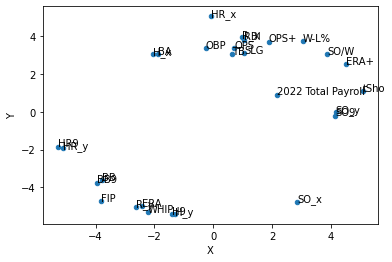

In [41]:
plot = data2D.plot.scatter(x='X', y='Y')
for i,r in data2D.iterrows():
    plot.text(r.X, r.Y, i)
plot

## Using current 2023 season data to predict what teams will make it to the World Series

We are only using current data of the statistics that were proven to have a high correlation with win percentage.

In [42]:
batting_data_2023 = pd.read_csv("data/batting_2023.csv")
pitching_data_2023 = pd.read_csv("data/pitching_2023.csv")

In [43]:
batting_data_2023.head()

,Tm,R,RBI,OBP,SLG,OPS,OPS+,TB
0,Arizona Diamondbacks,21,18,0.263,0.335,0.598,61,75
1,Atlanta Braves,39,36,0.357,0.484,0.841,123,120
2,Baltimore Orioles,34,33,0.343,0.478,0.821,129,98
3,Boston Red Sox,41,39,0.332,0.450,0.783,110,109
4,Chicago Cubs,28,26,0.343,0.398,0.741,100,70


In [44]:
pitching_data_2023.head()

,Tm,ERA,R,BB,ERA+,FIP,WHIP,H9,BB9,SO/W
0,Arizona Diamondbacks,5.25,36,36,92,6.25,1.500,8.1,5.4,1.64
1,Atlanta Braves,2.90,20,27,169,3.99,1.306,7.8,3.9,1.89
2,Baltimore Orioles,5.40,34,12,86,4.37,1.258,9.2,2.1,4.00
3,Boston Red Sox,5.57,41,31,89,5.77,1.556,9.6,4.4,2.00
4,Chicago Cubs,4.70,24,19,104,3.53,1.386,8.6,3.9,2.68


In [45]:
baseball_data_2023 = pd.merge(batting_data_2023, pitching_data_2023, on=["Tm"])
baseball_data_2023.head()

,Tm,R_x,RBI,OBP,SLG,OPS,OPS+,TB,ERA,R_y,BB,ERA+,FIP,WHIP,H9,BB9,SO/W
0,Arizona Diamondbacks,21,18,0.263,0.335,0.598,61,75,5.25,36,36,92,6.25,1.500,8.1,5.4,1.64
1,Atlanta Braves,39,36,0.357,0.484,0.841,123,120,2.90,20,27,169,3.99,1.306,7.8,3.9,1.89
2,Baltimore Orioles,34,33,0.343,0.478,0.821,129,98,5.40,34,12,86,4.37,1.258,9.2,2.1,4.00
3,Boston Red Sox,41,39,0.332,0.450,0.783,110,109,5.57,41,31,89,5.77,1.556,9.6,4.4,2.00
4,Chicago Cubs,28,26,0.343,0.398,0.741,100,70,4.70,24,19,104,3.53,1.386,8.6,3.9,2.68


## Normalizing current data

Using this normalized data, we can see how teams compare to the league average in every statistic. Depending on the statistic, having a big positive number could be good, or having a big negative number could be good.

In [46]:
norm = (baseball_data_2023 - baseball_data_2023.mean())/baseball_data_2023.std()
norm = norm.drop('Tm', axis=1)

norm.head()

C:\Users\marco\AppData\Local\Temp/ipykernel_12604/453986379.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  norm = (baseball_data_2023 - baseball_data_2023.mean())/baseball_data_2023.std()


,BB,BB9,ERA,ERA+,FIP,H9,OBP,OPS,OPS+,RBI,R_x,R_y,SLG,SO/W,TB,WHIP
0,2.021391,1.930412,0.658032,-0.624089,1.891079,-0.280559,-1.686754,-1.333661,-1.534960,-1.236601,-0.999982,0.681867,-1.063039,-0.977330,-0.861492,0.764074
1,0.715708,0.422278,-1.039416,0.942916,-0.319146,-0.492747,1.032883,1.094508,0.886605,1.011764,1.177398,-0.938411,1.042315,-0.760274,1.920839,-0.107698
2,-1.460431,-1.387484,0.766380,-0.746193,0.052485,0.497462,0.627831,0.894659,1.120950,0.637037,0.572570,0.479332,0.957536,1.071677,0.560588,-0.323395
3,1.296012,0.924989,0.889174,-0.685141,1.421650,0.780379,0.309576,0.514945,0.378858,1.386492,1.419329,1.188204,0.561899,-0.664770,1.240714,1.015720
4,-0.444900,0.422278,0.260757,-0.379880,-0.769015,0.073087,0.627831,0.095262,-0.011717,-0.237327,-0.153223,-0.533341,-0.172856,-0.074378,-1.170640,0.251795


In [47]:
#include: ERA+, OBP, OPS, OPS+, RBI, R_x, SLG, SO/W, TB, 
battingnorm = norm.loc[:, ['ERA+', 'OBP', 'OPS', 'OPS+', 'RBI', 'R_x', 'SLG', 'SO/W', 'TB']] 
battingnorm.sum(axis=1).sort_values()

11   -12.269489
9    -11.735296
29   -10.482075
0    -10.317908
19    -8.833066
14    -8.182464
17    -7.070678
21    -5.053054
8     -4.760094
20    -4.676729
23    -3.491651
16    -1.783867
4     -1.476929
22     0.773932
12     0.968006
6      1.327022
7      1.597545
10     1.828318
5      2.270401
28     2.459845
27     3.170407
3      4.461902
25     5.411931
2      5.696656
18     6.352045
15     7.031001
1      8.348956
24     9.131885
26    13.666237
13    15.637210
dtype: float64

In [48]:
#include: 
pitchingnorm = norm.loc[:, ['BB', 'BB9', 'ERA', 'FIP', 'H9', 'R_y', 'WHIP']] 
pitchingnorm.sum(axis=1).sort_values()

13   -12.919912
16    -9.727896
26    -9.527729
18    -9.452615
15    -6.247349
27    -5.140978
12    -5.021061
7     -3.731116
21    -2.026998
1     -1.759432
10    -1.613087
2     -1.375651
14    -0.747675
4     -0.739339
11     0.210440
24     0.658692
23     0.787068
6      1.284088
8      1.324329
28     2.051558
22     2.411950
29     3.071481
25     3.154716
17     4.665491
19     5.792074
9      6.362672
3      7.516127
0      7.666296
20     9.305288
5     13.768568
dtype: float64

## Choosing the best teams

The analysis shows that the best National League team so far this season is the Los Angeles Dodgers, and the best American League team so far this season is the Tampa Bay Rays.

## Credit

Everyone contributed to each part equally. This includes the web scraping, visualization, and analysis.